# Filtering nodes and edges in graphs

When you start working with graphs created from real dataset the graphs quickly become very large. In this case, you may want to filter the nodes and edges in the graph to make it easier to work with. In this notebook, we will show how to filter nodes and edges in a graph using `weather_model_graphs.filter_graph(...)`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import weather_model_graphs as wmg

In [2]:
def _create_fake_xy(N=10):
    x = np.linspace(0.0, N, N)
    y = np.linspace(0.0, N, N)
    xy_mesh = np.meshgrid(x, y)
    xy = np.stack([mg_coord.flatten() for mg_coord in xy_mesh], axis=1)  # Shaped (N, 2)
    return xy

As before, let's start from some fake grid coordinates (this is where our input/output data will reside)

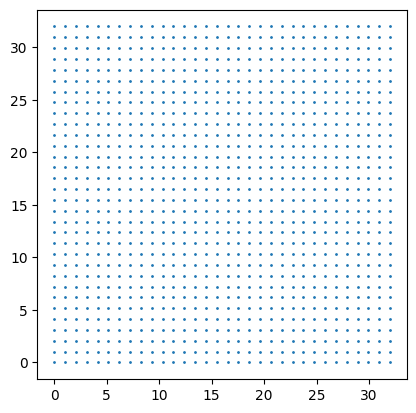

In [3]:
xy = _create_fake_xy(32)

fig, ax = plt.subplots()
ax.scatter(xy[:, 0], xy[:, 1], s=1)
ax.set_aspect(1)

In [4]:
graph = wmg.create.archetype.create_oskarsson_hierarchical_graph(
    coords=xy, max_num_levels=2
)
graph

2025-04-04 22:23:00.010 | DEBUG    | weather_model_graphs.create.base:create_all_graph_components:94 - No `coords_crs` given: Assuming `coords` contains in-projection Cartesian coordinates.
2025-04-04 22:23:00.011 | DEBUG    | weather_model_graphs.create.mesh.mesh:create_multirange_2d_mesh_graphs:134 - mesh_levels: 2, nleaf: [9 9]


Even with just a two-level hierarchy and only 32x32 grid points this graph is already quite complicated:

<Axes: >

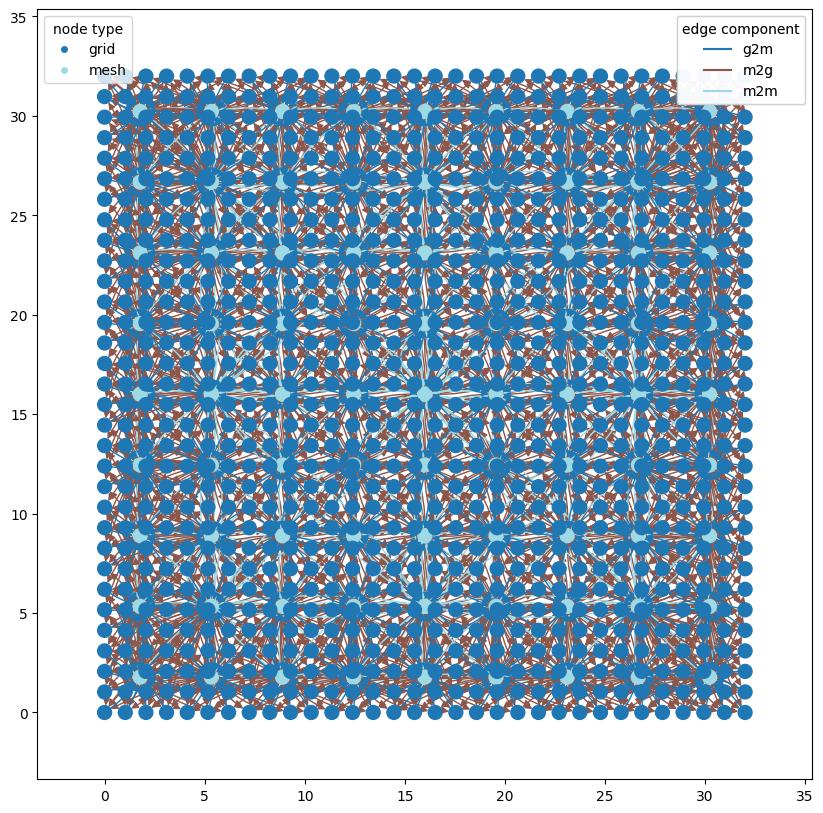

In [5]:
wmg.visualise.nx_draw_with_pos_and_attr(
    graph, edge_color_attr="component", node_color_attr="type"
)

<Axes: >

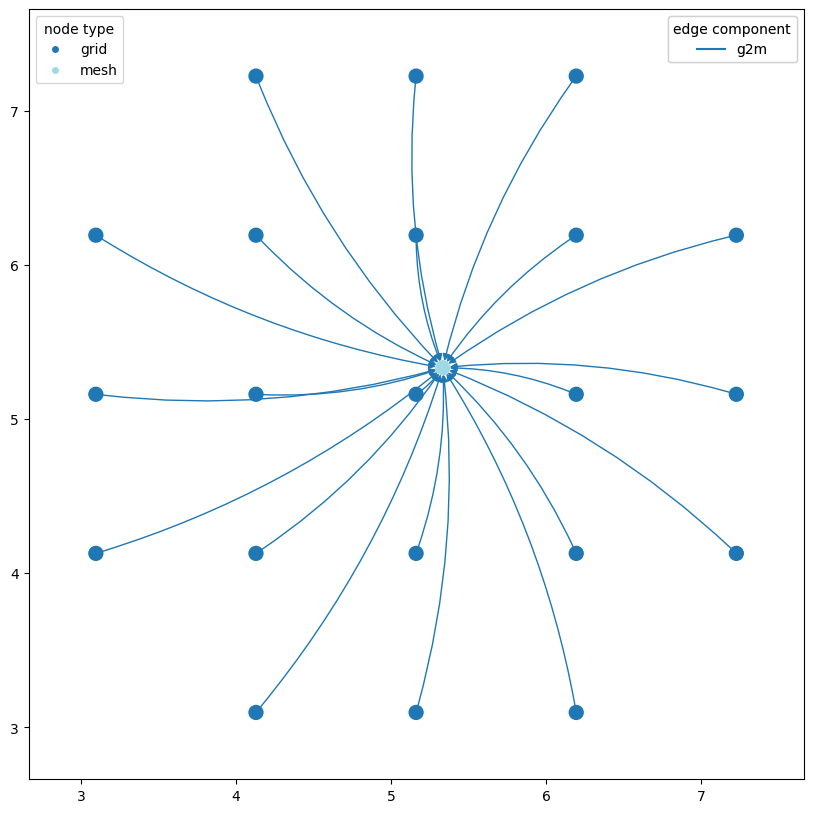

In [6]:
# let's take the 10th mesh node and plot the g2m nodes connected to it
subgraph = wmg.filter_graph(
    wmg.filter_graph(graph, node__type="mesh", node_limit=1, node_offset=10),
    edge__component="g2m",
)

wmg.visualise.nx_draw_with_pos_and_attr(
    subgraph, edge_color_attr="component", node_color_attr="type"
)

(-1.6, 10.0)

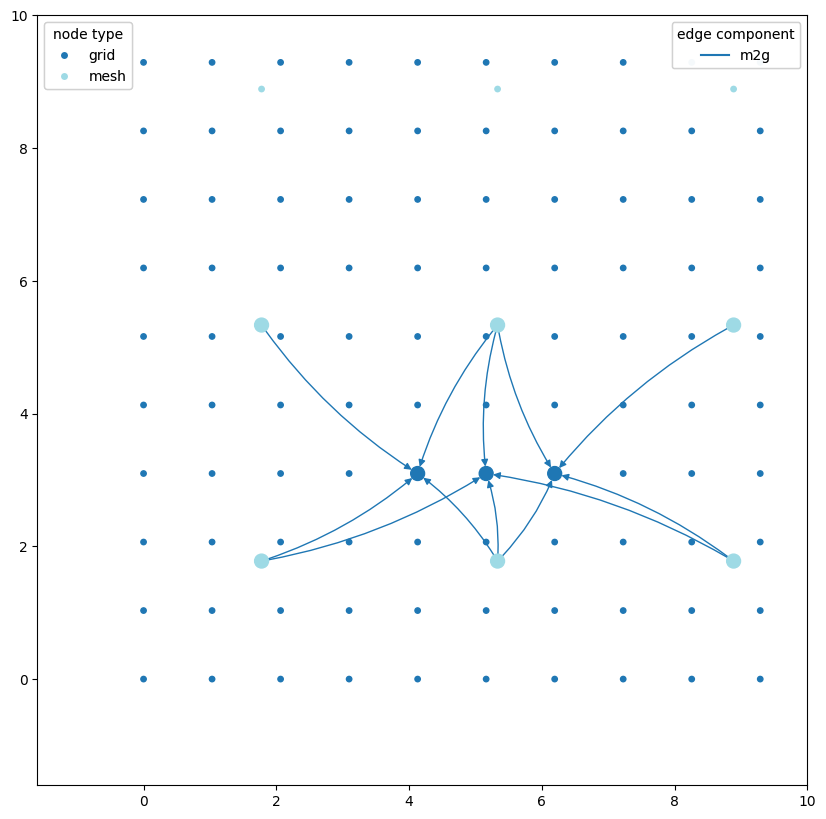

In [7]:
# and similarly lets take the 10th grid node plot the m2g nodes connected to it
n_offset = 100
grid_nodes_highlight_subgraph = wmg.filter_graph(
    wmg.filter_graph(graph, node__type="grid", node_limit=3, node_offset=n_offset),
    edge__component="m2g",
)

grid_nodes_subgraph = wmg.filter_graph(
    graph, node__type__in=["grid", "mesh"], retain="strict"
)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect(1)
wmg.visualise.nx_draw_with_pos_and_attr(
    ax=ax, graph=grid_nodes_subgraph, node_color_attr="type", node_size=15
)
wmg.visualise.nx_draw_with_pos_and_attr(
    ax=ax,
    graph=grid_nodes_highlight_subgraph,
    edge_color_attr="component",
    node_color_attr="type",
)
ax.set_xlim(None, 10)
ax.set_ylim(None, 10)

90th percentile of edge lengths: 4.33


Text(0.5, 1.0, 'Edges longer than 4.33 (90th percentile) in the m2g component')

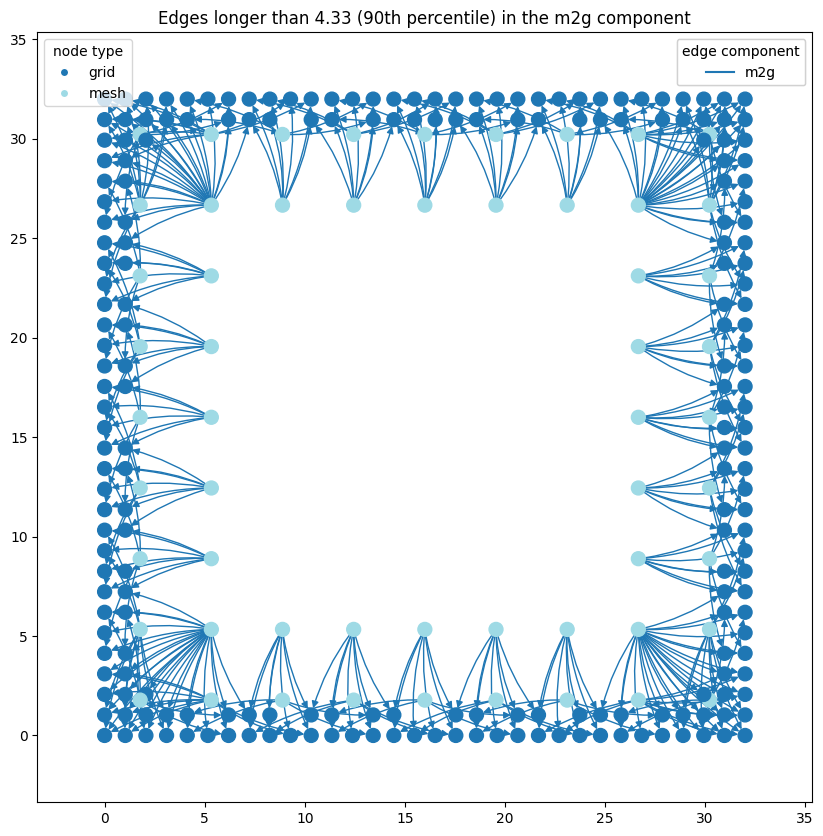

In [8]:
# let's look at the 90th percentile of longest edges, every edge has a `len`
# attribute that gives it length

percentile = 90
graph_m2g_edges = wmg.filter_graph(graph, edge__component="m2g")
lenths = np.array([data["len"] for _, _, data in graph_m2g_edges.edges(data=True)])
len_p = np.percentile(lenths, percentile)
print(f"90th percentile of edge lengths: {len_p:.2f}")

subgraph = wmg.filter_graph(graph_m2g_edges, edge__len__gt=len_p)

fig, ax = plt.subplots(figsize=(10, 10))
wmg.visualise.nx_draw_with_pos_and_attr(
    ax=ax, graph=subgraph, edge_color_attr="component", node_color_attr="type"
)
ax.set_title(
    f"Edges longer than {len_p:.2f} ({percentile}th percentile) in the m2g component"
)

99th percentile of edge lengths: 2.50


Text(0.5, 1.0, 'Edges longer than 2.50 (95th percentile) in g2m component')

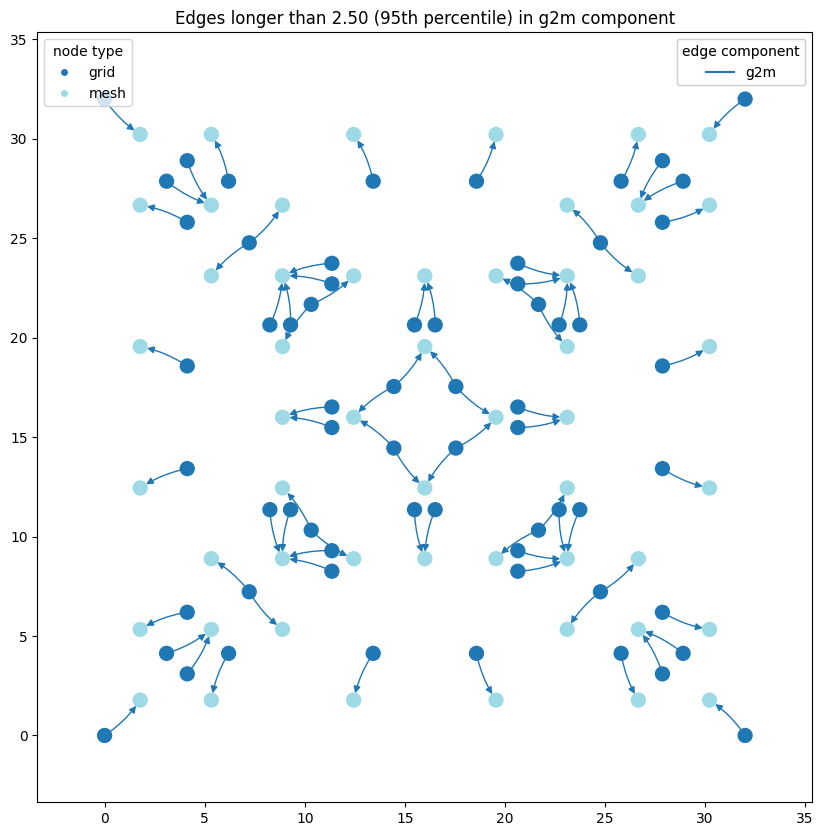

In [9]:
# where are the longest edges in the `g2m` component?
percentile = 95
graph_g2m_edges = wmg.filter_graph(graph, edge__component="g2m")
lenths = np.array([data["len"] for _, _, data in graph_g2m_edges.edges(data=True)])
len_p = np.percentile(lenths, percentile)
print(f"99th percentile of edge lengths: {len_p:.2f}")
subgraph = wmg.filter_graph(graph_g2m_edges, edge__len__gt=len_p)
fig, ax = plt.subplots(figsize=(10, 10))
wmg.visualise.nx_draw_with_pos_and_attr(
    ax=ax, graph=subgraph, edge_color_attr="component", node_color_attr="type"
)
ax.set_title(
    f"Edges longer than {len_p:.2f} ({percentile}th percentile) in g2m component"
)